# Metodología DiD de CodeInterpreter

# Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pycountry
from countryinfo import CountryInfo as CInfo # Se conecta con la informacion de cada país
import matplotlib.pyplot as plt
import  altair  as  alt # Graficos de promedios
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import  altair  as  alt

# Read Data

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/github/innovationgraph/main/data/languages.csv", delimiter=',')
data

,num_pushers,language,language_type,iso2_code,year,quarter
0,2066,HTML,markup,AE,2020,1
1,1627,CSS,markup,AE,2020,1
2,288,Jupyter Notebook,markup,AE,2020,1
3,108,Vue,markup,AE,2020,1
4,1734,JavaScript,programming,AE,2020,1
...,...,...,...,...,...,...
104437,198,TypeScript,programming,ZW,2023,4
104438,150,C,programming,ZW,2023,4
104439,140,Dockerfile,programming,ZW,2023,4
104440,140,PHP,programming,ZW,2023,4


In [3]:
# Filtro de EU
data = data[data.iso2_code != "EU"]

# Filtro de XK = Kosovo
data = data[data.iso2_code != "XK"]

In [4]:
# This will give you the count of rows with NaN values.
nan_rows_count = data.isna().any(axis=1).sum()
print(f"There are {nan_rows_count} rows with NaN values in the dataset.")

There are 35 rows with NaN values in the dataset.


In [5]:
data[data["iso2_code"].isnull()] = "NA"

C:\Users\ronco\AppData\Local\Temp\ipykernel_20540\143898119.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[data["iso2_code"].isnull()] = "NA"
C:\Users\ronco\AppData\Local\Temp\ipykernel_20540\143898119.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[data["iso2_code"].isnull()] = "NA"
C:\Users\ronco\AppData\Local\Temp\ipykernel_20540\143898119.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data[data["iso2_code"].isnull()] = "NA"


## Keep the 10 most used programming languages

In [6]:
top_program_lang = programming_languages = [
    "Python", "R", "SQL", "Java", "Scala",
    "Julia", "MATLAB", "C++", "JavaScript", "C#",
    "SAS", "Perl", "Ruby", "Go", "Bash",
    "Swift", "Kotlin", "PHP", "TypeScript", "Fortran"
]

In [7]:
data2 = data[data['language'].isin(top_program_lang)]
data2 = data2.reset_index(drop=True)
data2

,num_pushers,language,language_type,iso2_code,year,quarter
0,1734,JavaScript,programming,AE,2020,1
1,816,Python,programming,AE,2020,1
2,685,Java,programming,AE,2020,1
3,377,Ruby,programming,AE,2020,1
4,354,PHP,programming,AE,2020,1
...,...,...,...,...,...,...
22920,774,JavaScript,programming,ZW,2023,4
22921,391,Python,programming,ZW,2023,4
22922,198,TypeScript,programming,ZW,2023,4
22923,140,PHP,programming,ZW,2023,4


In [8]:
data2['year_quarter'] = data2['year'].astype(str) + '-Q' + data2['quarter'].astype(str)
data2
# Reseteamos el index
data2 = data2.reset_index(drop=True)
data2

,num_pushers,language,language_type,iso2_code,year,quarter,year_quarter
0,1734,JavaScript,programming,AE,2020,1,2020-Q1
1,816,Python,programming,AE,2020,1,2020-Q1
2,685,Java,programming,AE,2020,1,2020-Q1
3,377,Ruby,programming,AE,2020,1,2020-Q1
4,354,PHP,programming,AE,2020,1,2020-Q1
...,...,...,...,...,...,...,...
22920,774,JavaScript,programming,ZW,2023,4,2023-Q4
22921,391,Python,programming,ZW,2023,4,2023-Q4
22922,198,TypeScript,programming,ZW,2023,4,2023-Q4
22923,140,PHP,programming,ZW,2023,4,2023-Q4


In [9]:
# Creating a unique identifier
data2['unique_id'] = data2['iso2_code'] + '-' + data2['language']


In [10]:
import pandas as pd
import numpy as np

# Assume 'df' is your original DataFrame after reading the CSV file.
# 'unique_id' and 'year_quarter' are columns in your DataFrame.

# Create a DataFrame of unique identifiers
iso2_code = pd.DataFrame({'iso2_code': data2['iso2_code'].unique()})

# Create a DataFrame of unique identifiers for languages 
language = pd.DataFrame({'language': data2['language'].unique()})

# Create a DataFrame of all time periods
# time_periods = pd.DataFrame({'year_quarter': range(data2['year_quarter'].min(), data2['year_quarter'].max() + 1)})
year_quarter = pd.DataFrame({'year_quarter': data2['year_quarter'].unique()})

# Create the Cartesian product of unique_ids and time_periods
balanced_panel = iso2_code.merge(language, how='cross').merge(year_quarter, how='cross')

balanced_panel["unique_id"] = balanced_panel["iso2_code"] + "-" +balanced_panel["language"]
balanced_panel

# # Merge the balanced panel with the original data
balanced_df = balanced_panel.merge(data2, on=['unique_id', 'year_quarter'], how='left')

# # Merge the DataFrames with suffixes
balanced_df = balanced_panel.merge(data2, on=['unique_id', 'year_quarter'], how='left', suffixes=('', '_y'))

# # Now, drop the columns with '_y' suffix, which are from the right DataFrame
balanced_df = balanced_df.loc[:, ~balanced_df.columns.str.endswith('_y')]
balanced_df 


,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734,programming,2020,1
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299,programming,2020,2
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366,programming,2020,3
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468,programming,2020,4
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544,programming,2021,1
...,...,...,...,...,...,...,...,...
48635,LS,SQL,2022-Q4,LS-SQL,NaN,NaN,NaN,NaN
48636,LS,SQL,2023-Q1,LS-SQL,NaN,NaN,NaN,NaN
48637,LS,SQL,2023-Q2,LS-SQL,NaN,NaN,NaN,NaN
48638,LS,SQL,2023-Q3,LS-SQL,NaN,NaN,NaN,NaN


In [11]:
# Function to convert quarter format to integer
def quarter_to_int(quarter_string):
    year, q = quarter_string.split('-')
    year = int(year)
    quarter_number = int(q[1])  # Q1, Q2, Q3, Q4 -> 1, 2, 3, 4
    base_year = 2020  # Adjust based on your balanced_df, or set dynamically
    return 4 * (year - base_year) + quarter_number

# Applying the function
balanced_df['quarter'] = balanced_df['year_quarter'].apply(quarter_to_int)
balanced_df['year'] = balanced_df['year_quarter'].str.split('-').str[0]
balanced_df.loc[balanced_df["num_pushers"].isnull(), "num_pushers"] = 0
balanced_df

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734,programming,2020,1
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299,programming,2020,2
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366,programming,2020,3
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468,programming,2020,4
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544,programming,2021,5
...,...,...,...,...,...,...,...,...
48635,LS,SQL,2022-Q4,LS-SQL,0,NaN,2022,12
48636,LS,SQL,2023-Q1,LS-SQL,0,NaN,2023,13
48637,LS,SQL,2023-Q2,LS-SQL,0,NaN,2023,14
48638,LS,SQL,2023-Q3,LS-SQL,0,NaN,2023,15


## Per capita measures

In [12]:
# Definimos una función que convierte los nombres de países en códigos iso2
def country_to_iso2(country_name):
    try:
        # Intentamos obtener el código iso2 del país usando pycountry
        return pycountry.countries.get(name=country_name).alpha_2
    except AttributeError:
        try:
            # Manejamos casos especiales donde el nombre del país no coincide exactamente con la base de datos de pycountry
            special_cases = {
                "Czechia (Czech Republic)": "CZ",
                "Congo (Congo-Brazzaville)": "CG",
                "Holy See": "VA",
                "Timor-Leste (East Timor)": "TL",
                "Ukraine (with certain exceptions)": "UA",
                "Taiwan": "TW",
                "Bolivia": "BO",
                "Tanzania": "TZ",
                "South Korea": "KR",
                "Moldova": "MD",
                "Brunei": "BN"
            }
            return special_cases[country_name]
        except KeyError:
            return None

# Creamos una lista de países y obtenemos sus códigos iso2 usando la función country_to_iso2
gpt_countries_list = [
    "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia", "Australia", "Austria",
    "Azerbaijan", "Bahamas", "Bangladesh", "Barbados", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia",
    "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina Faso", "Cabo Verde", "Canada",
    "Chile", "Colombia", "Comoros", "Congo (Congo-Brazzaville)", "Costa Rica", "Côte d'Ivoire", "Croatia", "Cyprus",
    "Czechia", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Estonia", "Fiji",
    "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
    "Guinea-Bissau", "Guyana", "Haiti", "Holy See", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iraq",
    "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Kuwait",
    "Kyrgyzstan", "Latvia", "Lebanon", "Lesotho", "Liberia", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar",
    "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
    "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
    "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway",
    "Oman", "Pakistan", "Palau", "Palestine, State of", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines",
    "Poland", "Portugal", "Qatar", "Romania", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal",
    "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "South Africa",
    "South Korea", "Spain", "Sri Lanka", "Suriname", "Sweden", "Switzerland", "Taiwan", "Tanzania", "Thailand",
    "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey", "Tuvalu", "Uganda", "Ukraine",
    "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Vanuatu", "Zambia"
]

gpt_countries_iso = [country_to_iso2(country) for country in gpt_countries_list]

# Agregamos una nueva columna gpt_available, con valor 1 si el código iso2 está en la lista gpt_countries_iso, y 0 en caso contrario
balanced_df["gpt_available"] = balanced_df["iso2_code"].apply(lambda row: 1 if row in gpt_countries_iso else 0)



In [13]:
countries = data2.iso2_code.unique()

def create_populations_dictionary():
    country_populations = {}
    special_cases = {"MM": 54688774, "PS": 5483450, "ME": 602445, "AD":79824}
    # special_cases = {}
    for country in countries:
        try:
            country_populations.update({country: CInfo(country).info()["population"]})
        except KeyError:
            try:
                fallback_name = pycountry.countries.lookup(country).name
                country_populations.update({country: CInfo(fallback_name).info()["population"]})
            except KeyError:
                print(country)
                country_populations.update({country: special_cases[country]})

    return country_populations

country_populations = create_populations_dictionary()

ME
MM
PS
AD


# Creación de variables "population", "pushes_pc", "time", "Post" & "Treatment"

**population**

In [14]:
balanced_df["population"] = balanced_df["iso2_code"].map(country_populations)

**pushes_pc**

In [15]:
balanced_df["num_pushers_pc"] = (balanced_df["num_pushers"] / balanced_df["population"])*100000

**time**

In [16]:
balanced_df.num_pushers_pc.describe()

count     48640.0
unique    21552.0
top           0.0
freq      25715.0
Name: num_pushers_pc, dtype: float64

**Post**



In [17]:
balanced_df.year = balanced_df.year.astype(int)

In [18]:
# Aplicar la condición y crear la columna post_CI
balanced_df['post_gpt'] = balanced_df['quarter'] >= 12
balanced_df['post_gpt'] = balanced_df['post_gpt'].astype(int)
balanced_df

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter,gpt_available,population,num_pushers_pc,post_gpt
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734,programming,2020,1,1,9446000,18.356976,0
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299,programming,2020,2,1,9446000,24.338344,0
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366,programming,2020,3,1,9446000,25.047639,0
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468,programming,2020,4,1,9446000,26.127461,0
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544,programming,2021,5,1,9446000,26.932035,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48635,LS,SQL,2022-Q4,LS-SQL,0,NaN,2022,12,1,2098000,0.0,1
48636,LS,SQL,2023-Q1,LS-SQL,0,NaN,2023,13,1,2098000,0.0,1
48637,LS,SQL,2023-Q2,LS-SQL,0,NaN,2023,14,1,2098000,0.0,1
48638,LS,SQL,2023-Q3,LS-SQL,0,NaN,2023,15,1,2098000,0.0,1


**Treatment**

In [19]:
balanced_df['Treatment'] = balanced_df.gpt_available * balanced_df.post_gpt
balanced_df

,iso2_code,language,year_quarter,unique_id,num_pushers,language_type,year,quarter,gpt_available,population,num_pushers_pc,post_gpt,Treatment
0,AE,JavaScript,2020-Q1,AE-JavaScript,1734,programming,2020,1,1,9446000,18.356976,0,0
1,AE,JavaScript,2020-Q2,AE-JavaScript,2299,programming,2020,2,1,9446000,24.338344,0,0
2,AE,JavaScript,2020-Q3,AE-JavaScript,2366,programming,2020,3,1,9446000,25.047639,0,0
3,AE,JavaScript,2020-Q4,AE-JavaScript,2468,programming,2020,4,1,9446000,26.127461,0,0
4,AE,JavaScript,2021-Q1,AE-JavaScript,2544,programming,2021,5,1,9446000,26.932035,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48635,LS,SQL,2022-Q4,LS-SQL,0,NaN,2022,12,1,2098000,0.0,1,1
48636,LS,SQL,2023-Q1,LS-SQL,0,NaN,2023,13,1,2098000,0.0,1,1
48637,LS,SQL,2023-Q2,LS-SQL,0,NaN,2023,14,1,2098000,0.0,1,1
48638,LS,SQL,2023-Q3,LS-SQL,0,NaN,2023,15,1,2098000,0.0,1,1


In [20]:
unique_values = balanced_df['unique_id'].nunique()
print(unique_values)

3040


### Check Variables

<Axes: >

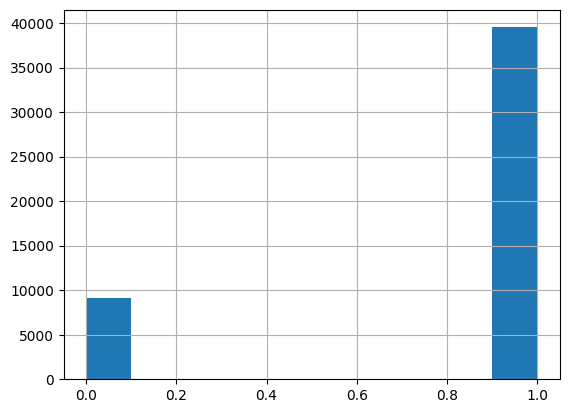

In [21]:
balanced_df.gpt_available.hist()

In [22]:
balanced_df.to_csv("../output/data.csv")

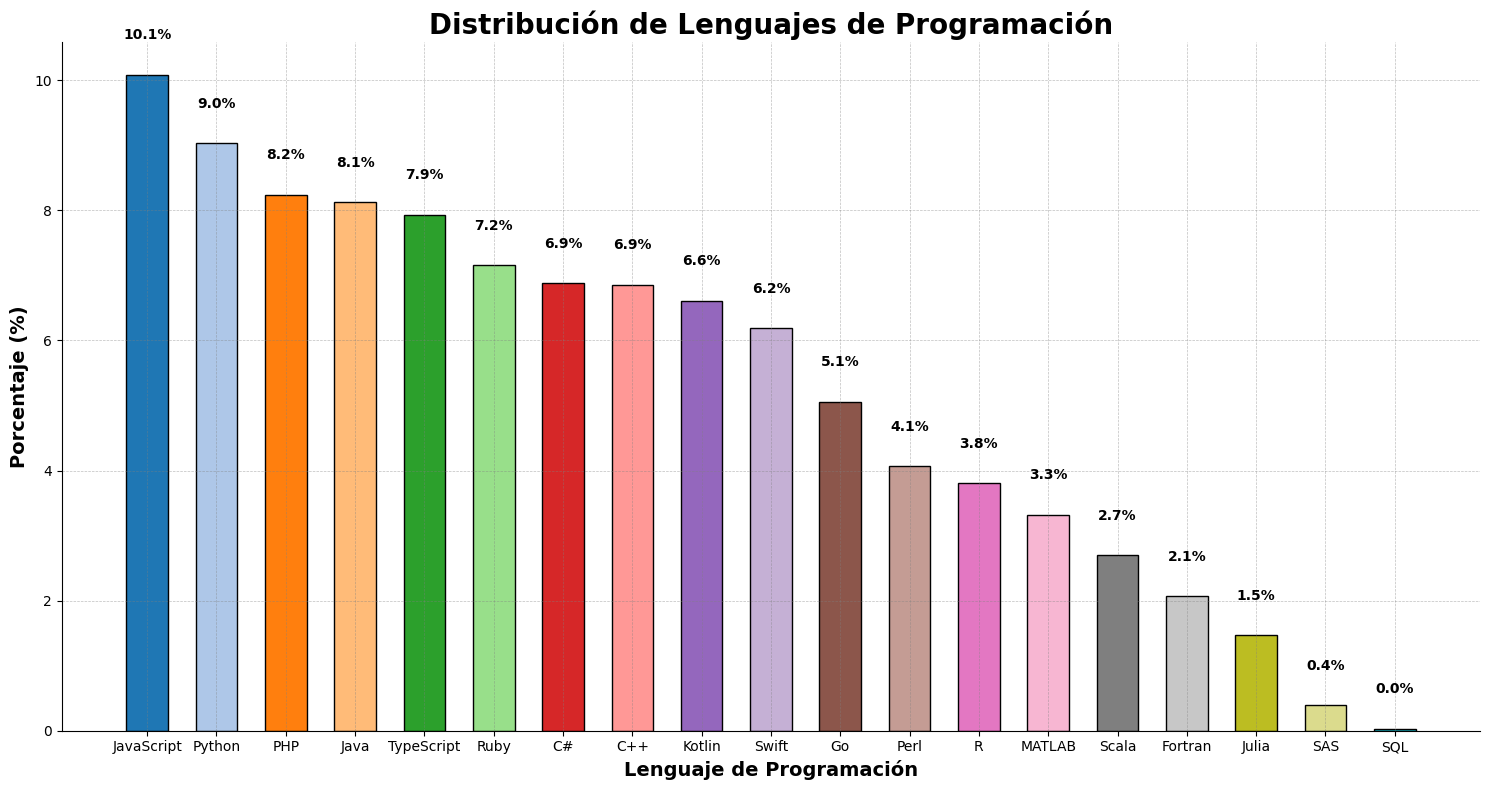

In [23]:
# Asegúrate de que 'data' es tu DataFrame y 'language' es la columna correcta
distribucion_porcentual = data2['language'].value_counts(normalize=True) * 100

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(15, 8))
colors = plt.cm.tab20(np.arange(len(distribucion_porcentual))/len(distribucion_porcentual))  # Colores distintos para cada barra

# Crear barras
bars = ax.bar(distribucion_porcentual.index, distribucion_porcentual, color=colors, width=0.6, edgecolor='black')

# Añadir texto en cada barra
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom', color='black', fontweight='bold', fontsize=10)

# Título y etiquetas
ax.set_title('Distribución de Lenguajes de Programación', fontsize=20, color='black', fontweight='bold')
ax.set_xlabel('Lenguaje de Programación', fontsize=14, color='black', fontweight='bold')
ax.set_ylabel('Porcentaje (%)', fontsize=14, color='black', fontweight='bold')

# Configuraciones de ejes y fondo
ax.set_facecolor('white')  # Fondo blanco para más claridad
fig.set_facecolor('white')
ax.tick_params(colors='black', which='both')  # Color de los ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Rejilla sutil
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [24]:
# Aumentar el límite máximo de filas
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')

# Suponiendo que 'data' es tu DataFrame
data_aggregated = balanced_df.groupby('language').size().reset_index(name='counts')
data_aggregated['percentage'] = (data_aggregated['counts'] / data_aggregated['counts'].sum()) * 100


In [25]:
alt.Chart(data_aggregated).mark_bar()

c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [26]:
# Convertir 'num_pushers' a numérico si es necesario
balanced_df['num_pushers_pc'] = pd.to_numeric(balanced_df['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_aggregated = balanced_df.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

In [27]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48640 entries, 0 to 48639
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso2_code       48640 non-null  object 
 1   language        48640 non-null  object 
 2   year_quarter    48640 non-null  object 
 3   unique_id       48640 non-null  object 
 4   num_pushers     48640 non-null  object 
 5   language_type   22925 non-null  object 
 6   year            48640 non-null  int32  
 7   quarter         48640 non-null  int64  
 8   gpt_available   48640 non-null  int64  
 9   population      48640 non-null  int64  
 10  num_pushers_pc  48640 non-null  float64
 11  post_gpt        48640 non-null  int32  
 12  Treatment       48640 non-null  int64  
dtypes: float64(1), int32(2), int64(4), object(6)
memory usage: 4.5+ MB


In [45]:
# Grafico de líneas con puntos superpuestos
alt.Chart(data_aggregated, height=600, width=750).mark_line(point=True, color='darkblue').encode(
    y='num_pushers_pc',
    x='year_quarter',
    color='language',
    tooltip=['num_pushers_pc', 'year_quarter', 'language']
).interactive().properties(
    title='Cantidad de pushes per capita según lenguaje de programación de 2020-2023'
)

c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [29]:
data_con_gpt = balanced_df[balanced_df['gpt_available'] == 1]

In [30]:
# Aumentar el límite máximo de filas
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')

# Suponiendo que 'data' es tu DataFrame
data_agg_1 = data_con_gpt.groupby('language').size().reset_index(name='counts')
data_agg_1['percentage'] = (data_agg_1['counts'] / data_agg_1['counts'].sum()) * 100

alt.Chart(data_agg_1).mark_bar()


c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [31]:
# Convertir 'num_pushers' a numérico si es necesario
data_con_gpt['num_pushers_pc'] = pd.to_numeric(data_con_gpt['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_agg_1 = data_con_gpt.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

C:\Users\ronco\AppData\Local\Temp\ipykernel_20540\3818098338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_con_gpt['num_pushers_pc'] = pd.to_numeric(data_con_gpt['num_pushers_pc'], errors='coerce')


In [43]:
# Grafico de líneas con puntos superpuestos
alt.Chart(data_agg_1, height=500, width=650).mark_line(point=True, color='darkblue').encode(
    y='num_pushers_pc',
    x='year_quarter',
    color='language',
    tooltip=['num_pushers_pc', 'year_quarter', 'language']
).interactive().properties(
    title='Cantidad de pushes per capita según lenguaje de programación de 2020-2023 en países con ChatGPT disponible'
)

c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [33]:
data_sin_gpt = balanced_df[balanced_df['gpt_available'] == 0]

In [36]:
# Aumentar el límite máximo de filas
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')

# Suponiendo que 'data' es tu DataFrame
data_agg_2 = data_con_gpt.groupby('language').size().reset_index(name='counts')
data_agg_2['percentage'] = (data_agg_2['counts'] / data_agg_2['counts'].sum()) * 100

alt.Chart(data_agg_2).mark_bar()


c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [37]:
# Convertir 'num_pushers' a numérico si es necesario
data_sin_gpt['num_pushers_pc'] = pd.to_numeric(data_sin_gpt['num_pushers_pc'], errors='coerce')

# Agregar datos por 'year_quarter' y 'language'
data_agg_2 = data_sin_gpt.groupby(['year_quarter', 'language'], as_index=False).agg(
    total_pushers=('num_pushers_pc', 'sum')
).rename(columns={'total_pushers': 'num_pushers_pc'})

C:\Users\ronco\AppData\Local\Temp\ipykernel_20540\949310509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sin_gpt['num_pushers_pc'] = pd.to_numeric(data_sin_gpt['num_pushers_pc'], errors='coerce')


In [39]:
# Grafico de líneas con puntos superpuestos
alt.Chart(data_agg_2, height=500, width=650).mark_line(point=True, color='darkblue').encode(
    y='num_pushers_pc',
    x='year_quarter',
    color='language',
    tooltip=['num_pushers_pc', 'year_quarter', 'language']
).interactive().properties(
    title='Cantidad de pushes per capita según lenguaje de programación de 2020-2023 en países sin ChatGPT disponible'
)

c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
c:\PYTHON\Python39\lib\site-packages\altair\utils\core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)